In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path


# Preprocess image (resize, normalize)
IMG_SIZE = (256, 256)
NUM_CLASSES = 21 # 20 classes + the background

# Transformation class
class VOCTransforms:
    def __init__(self, img_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=mean, std=std),
        ])
        self.target_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToImage(),
            transforms.ToDtype(torch.long, scale=False),
        ])
    def __call__(self, img, target):
        image = self.transform(img)
        target = self.target_transform(target)
        target = target.squeeze(0)
        return image, target

# Load dataset, image and segmentation mask

voc_transforms = VOCTransforms(IMG_SIZE)

DATA_ROOT = '/Users/ianyoo/Documents/School/ECS 171/Final Project/subject-isolation/data'

train_dataset = VOCSegmentation(
    root=DATA_ROOT,
    year='2012',
    image_set='train',
    download=False,
    transforms=voc_transforms
)

val_dataset = VOCSegmentation(
    root=DATA_ROOT,
    year='2012',
    image_set='val',
    download=False,
    transforms=voc_transforms
)

BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Had to set num_workers to 0 for VOCTransforms parallel error

In [5]:
class FCN(nn.Module):
    def __init__(self, n_classes):
        super(FCN, self).__init__()
        self.n_classes = n_classes

        # VGG-16 Based Encoder (downsampling): conv blocks + maxpool
        # Block 1: 3 in -> 64 out
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output spatial halved

        # Block 2: 64 in -> 128 out
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3: 128 in -> 256 out
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4: 256 in -> 512 out
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5: 512 in -> 512 out
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Final 1x1 conv
        self.classifier = nn.Conv2d(512, n_classes, kernel_size=1)

        # Decoder (unsampling):
        self.unsample = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=64, stride=32, padding=16, bias=False)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)

        x = self.classifier(x)

        x = self.unsample(x)
        return x

In [6]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = FCN(n_classes=NUM_CLASSES).to(device)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss(ignore_index=255) # loss func
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

print("Train start")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'fcn_voc_final.pth')
print("Saved fcn_voc_final.pth")

Using device: mps
Train start
Epoch 1/50 | Train Loss: 1.6650 | Val Loss: 1.3059
Epoch 2/50 | Train Loss: 1.2814 | Val Loss: 1.2539
Epoch 3/50 | Train Loss: 1.2590 | Val Loss: 1.2504
Epoch 4/50 | Train Loss: 1.2562 | Val Loss: 1.2506
Epoch 5/50 | Train Loss: 1.2346 | Val Loss: 1.2170
Epoch 6/50 | Train Loss: 1.2364 | Val Loss: 1.2083
Epoch 7/50 | Train Loss: 1.2315 | Val Loss: 1.2037
Epoch 8/50 | Train Loss: 1.2272 | Val Loss: 1.3519
Epoch 9/50 | Train Loss: 1.2295 | Val Loss: 1.2156
Epoch 10/50 | Train Loss: 1.2007 | Val Loss: 1.2046
Epoch 11/50 | Train Loss: 1.1949 | Val Loss: 1.1740
Epoch 12/50 | Train Loss: 1.1984 | Val Loss: 1.1991
Epoch 13/50 | Train Loss: 1.1874 | Val Loss: 1.1732
Epoch 14/50 | Train Loss: 1.1807 | Val Loss: 1.1690
Epoch 15/50 | Train Loss: 1.1647 | Val Loss: 1.1574
Epoch 16/50 | Train Loss: 1.1692 | Val Loss: 1.1759
Epoch 17/50 | Train Loss: 1.1406 | Val Loss: 1.1799
Epoch 18/50 | Train Loss: 1.1262 | Val Loss: 1.1376
Epoch 19/50 | Train Loss: 1.1238 | Val Loss

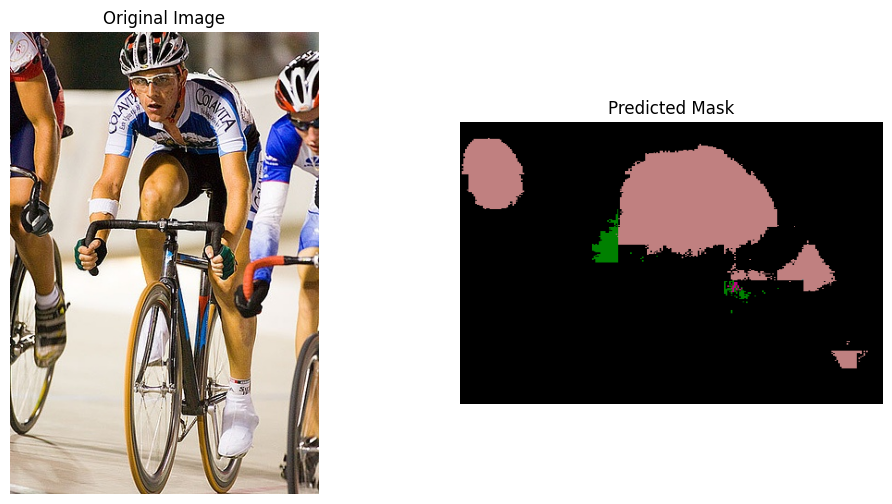

In [8]:
def predict_and_visualize(model, image_path, device, transforms_func, num_classes):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_size = image.size[::-1] # H, W

    # Use only the image transform part for prediction
    input_tensor = transforms_func.transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    # Get the prediction (class with highest score)
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Resize mask back to original image size
    pred_mask_pil = Image.fromarray(pred_mask.astype(np.uint8)).resize(original_size, Image.NEAREST)

    # Create a colormap for visualization (PASCAL VOC standard)
    def create_pascal_label_colormap():
        colormap = np.zeros((256, 3), dtype=int)
        ind = np.arange(256, dtype=int)
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        return colormap

    colormap = create_pascal_label_colormap()
    colored_mask = colormap[pred_mask_pil]

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(colored_mask.astype(np.uint8))
    plt.axis('off')
    plt.show()

# --- Example Prediction ---
# Load your trained model (if not already loaded)
# model.load_state_dict(torch.load('unet_voc_final.pth'))
# model.to(device)

# Choose an image from your validation set or a new one
# (Make sure to get the path correctly)
try:
    image_path, _ = val_dataset.images[4], val_dataset.masks[4] # Example path
    predict_and_visualize(model, image_path, device, voc_transforms, NUM_CLASSES)
except Exception as e:
     print(f"Could not load image for prediction: {e}")
     print("Please provide a valid image path.")

In [7]:
# Define FCN model:
    # Use convolutional layers to extract features
    # Replace fully connected layers with 1x1 convolutions
    # Upsample with transpose convolutions or bilinear upsampling

# Forward pass image through FCN → get pixel-wise class scores
# Compute loss with segmentation mask (e.g., cross-entropy)
# Backpropagate and update weights

# After training, use FCN to predict segmentation map for new images